In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

from sklearn.datasets import load_digits, fetch_openml
from sklearn.utils import check_random_state

from sklearn.ensemble import RandomForestClassifier as RF
from oblique_forests.sporf import ObliqueForestClassifier as SPORF
from oblique_forests.morf import Conv2DObliqueForestClassifier as MORF

sns.set_palette('Set1')
mpl.rcParams.update({
    "axes.titlesize": "xx-large",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "xtick.bottom": False,
    "ytick.left": False,
    "image.cmap": "inferno",
})

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Digits Dataset
These are 8x8 images of handwritten digits from `sklearn.datasets`

In [2]:
from sklearn.datasets import load_digits

images, labels = load_digits(return_X_y=True)

# Get 100 samples of 3s and 5s
n = 100
threes = np.where(labels == 3)[0][:(n // 2)]
fives = np.where(labels == 5)[0][:(n // 2)]
idx = np.concatenate((threes, fives))

# Subset train data
X = images[idx]
y = labels[idx]

# Apply random shuffling
permuted_idx = np.random.permutation(len(idx))
X = X[permuted_idx]
y = y[permuted_idx]

print(X.shape, y.shape)

(100, 64) (100,)


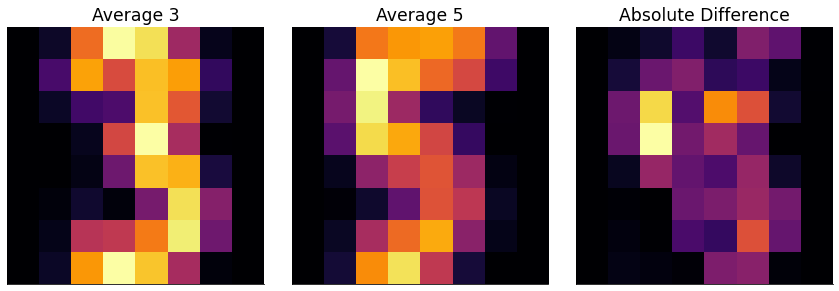

In [3]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
avg_3 = images[threes].mean(axis=0).reshape(8, 8)
avg_5 = images[fives].mean(axis=0).reshape(8, 8)
diff = np.abs(avg_3 - avg_5)

axs[0].imshow(avg_3)
axs[0].set_title("Average 3")

axs[1].imshow(avg_5)
axs[1].set_title("Average 5")

axs[2].imshow(diff)
axs[2].set_title("Absolute Difference")
for ax in axs:
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
fig.tight_layout()

## `RF` vs `SPORF` runtimes

In [4]:
def time_clf_digits(clf, ns, random_state=None):
    runtimes = np.empty(len(ns))
    rng = check_random_state(random_state)
    images, labels = load_digits(return_X_y=True)
    for i, n in enumerate(ns):
        # Get only 3s and 5s
        threes = np.where(labels == 3)[0][:(n // 2)]
        fives = np.where(labels == 5)[0][:(n // 2)]
        idx = np.concatenate((threes, fives))
        X = images[idx]
        y = labels[idx]

        # Shuffle samples
        permuted_idx = rng.permutation(len(idx))
        X = X[permuted_idx].reshape(n, -1)
        y = y[permuted_idx].reshape(n)

        # Begin timing
        start = time.time()
        clf.fit(X, y)
        runtimes[i] = time.time() - start
    return runtimes

In [5]:
def rename_clf(clf):
    if isinstance(clf, RF):
        return "RF"
    elif isinstance(clf, SPORF):
        return "SPORF"
    elif isinstance(clf, MORF):
        return "MORF"

In [6]:
ns = [10, 20, 40, 50, 100, 150, 200, 300]

clfs = [
    RF(random_state=0, n_jobs=1),
    SPORF(random_state=0, n_jobs=1),
    # MORF(random_state=0, image_height=8, image_width=8, n_jobs=1)  # Too slow
]

runtimes = []
for clf in clfs:
    runtimes.append(time_clf_digits(clf, ns, random_state=0))

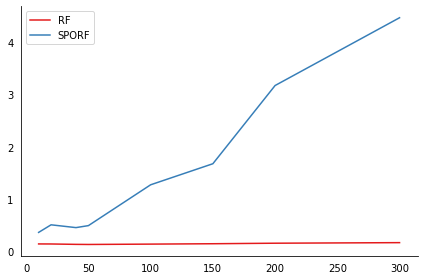

In [7]:
fig, ax = plt.subplots()
for runtime, clf in zip(runtimes, clfs):
    ax.plot(ns, runtime, label=rename_clf(clf))
ax.legend()
fig.tight_layout();

## MNIST Dataset
These are 28x28 images of handwritten digits from `keras.datasets`

In [8]:
from sklearn.datasets import fetch_openml

images, labels = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

n = 100
threes = np.where(labels == '3')[0][:(n // 2)]
fives = np.where(labels == '5')[0][:(n // 2)]
idx = np.concatenate((threes, fives))

# Subset train data
X = images[idx]
y = labels[idx]

# Apply random shuffling
permuted_idx = np.random.permutation(len(idx))
X = X[permuted_idx]
y = y[permuted_idx]

print(X.shape, y.shape)

(100, 784) (100,)


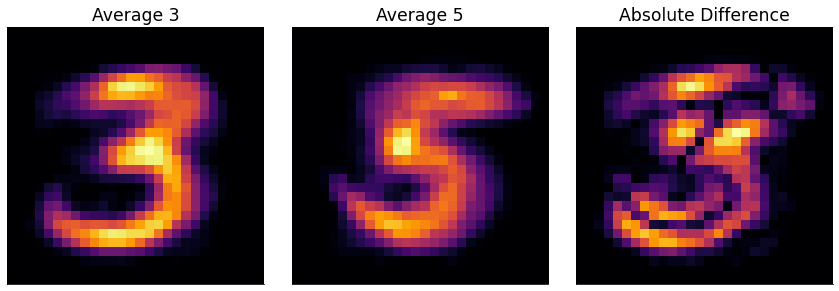

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
avg_3 = images[threes].mean(axis=0).reshape(28, 28)
avg_5 = images[fives].mean(axis=0).reshape(28, 28)
diff = np.abs(avg_3 - avg_5)

axs[0].imshow(avg_3)
axs[0].set_title("Average 3")

axs[1].imshow(avg_5)
axs[1].set_title("Average 5")

axs[2].imshow(diff)
axs[2].set_title("Absolute Difference")
for ax in axs:
    ax.tick_params(
        axis="both",
        which="both",
        bottom=False,
        left=False,
        labelbottom=False,
        labelleft=False,
    )
fig.tight_layout()

In [10]:
def time_clf_mnist(clf, ns, random_state=None):
    runtimes = np.empty(len(ns))
    rng = check_random_state(random_state)
    images, labels = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    for i, n in enumerate(ns):
        # Get only 3s and 5s
        threes = np.where(labels == '3')[0][:(n // 2)]
        fives = np.where(labels == '5')[0][:(n // 2)]
        idx = np.concatenate((threes, fives))
        X = images[idx]
        y = labels[idx]

        # Shuffle samples
        permuted_idx = rng.permutation(len(idx))
        X = X[permuted_idx]
        y = y[permuted_idx]

        # Begin timing
        start = time.time()
        clf.fit(X, y)
        runtimes[i] = time.time() - start
    return runtimes

In [11]:
ns = [10, 20, 40, 50, 100, 150, 200, 300, 500]

clfs = [
    RF(random_state=0, n_jobs=1),
    SPORF(random_state=0, n_jobs=1),
    # MORF(random_state=0, image_height=8, image_width=8, n_jobs=1)  # Too slow
]

runtimes = []
for clf in clfs:
    runtimes.append(time_clf_mnist(clf, ns, random_state=0))

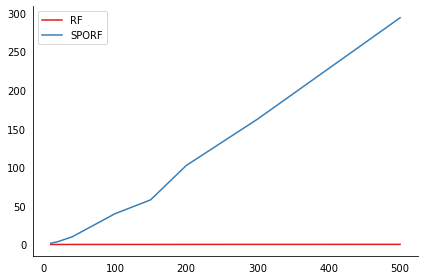

In [12]:
fig, ax = plt.subplots()
for runtime, clf in zip(runtimes, clfs):
    ax.plot(ns, runtime, label=rename_clf(clf))
ax.legend()
fig.tight_layout();